## Pradeep Mundlik
### Assignment-1
#### Problem-3

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


In [16]:
# creating datasets
theta = torch.linspace(0, 2*np.pi, 500)
D1 = torch.empty([500, 2])
D1[:, 0], D1[:, 1] = 2*torch.cos(theta), 2*torch.sin(theta)
D2 = torch.empty([500, 2])
D2[:, 0], D2[:, 1] = 5*torch.cos(theta), 5*torch.sin(theta)
noise = torch.normal(0.0, 1.0, [500, 2])
D1 += noise
D2 += noise


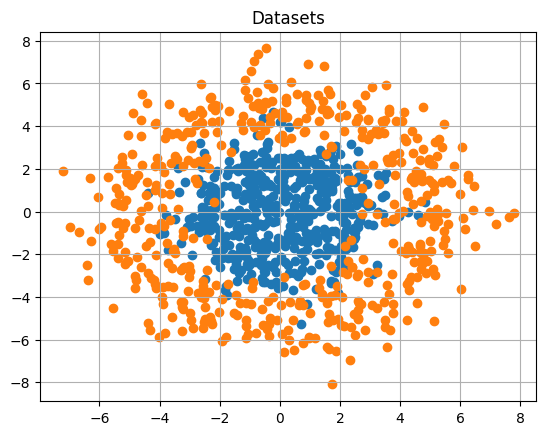

In [17]:
# ploting datapoints
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.title('Datasets')
plt.grid()


In [18]:
# Creating X(input) and Y(output labels)
X = torch.empty([1000, 3]).fill_(1.0)
X[::2, :2] = D1
X[1::2, :2] = D2
Y = torch.empty([1000, 1])
Y[::2] = 1.0
Y[1::2] = 0


Activation function used here is **Sigmoid** function
$$ \sigma(z) = \frac{1}{1+\exp(-z)} $$

Loss functions used is **Log Loss**
$$L =  -y_t.\log(y_p)-(1-y_t).\log(1-y_p)

In [19]:

def sigmoid(z):
    return 1/(1+torch.exp(-z))


def logloss(y_t, y_p):
    if y_p.item() == 1.0:
        y_p -= 0.000001
    return -1*y_t*(torch.log(y_p)) - (1-y_t)*(torch.log(1-y_p))


$X$ is input  <br>
$W^l_{ij}$ is weight from $j^th$ neuron in $(l-1)$ layer to $i^th$ neuron in $l$ layer <br>
$W^1$ is is matrix of such weights for hidden layer and $W^2$ is matrix of such weights for output layer <br>
$s_1 = X\times W^1$ <br>
$x_1 = \sigma(s_1)$ <br>
$s_2 = X\times W^2$ <br>
$y_p = \sigma(s_1)$ <br>
$y_t$ is truth value <br>
**For back propogation** :- <br>
$$\frac{\partial L}{\partial W^2_{1i}} = (y_p-y_t)*x_1[i]$$
$$\left[\frac{\partial L}{\partial W^2}\right] = (y_p-y_t)\times \bold{x_1}$$
$$\frac{\partial L}{\partial W^1_{ij}} = (y_p-y_t)*W^2_{1i}*x_1[i]*(1-x_1[i])*X[j]

In [20]:
# Creating a class for MultiLayered perceptron
class MLP:
    def __init__(self, params=None) -> None:
        if (params == None):
            self.inputlayer = 2  # number of neurons in input layer
            self.hiddenlayer = 12  # number of neurons in hidden layer
            self.outputlayer = 1  # number of neurons in output layer
            self.learning_rate = 0.01
            self.max_epochs = 500
        else:
            self.inputlayer = params['inputlayer']
            self.hiddenlayer = params['hiddenlayer']
            self.outputlayer = params['outputlayer']
            self.learning_rate = params['learning_rate']
            self.max_epochs = params['max_epochs']

        # initializing bias and weights
        # adding extra one row in weights matrix to companset bias
        self.weights_hidden = torch.rand([self.inputlayer+1, self.hiddenlayer])
        self.weights_output = torch.rand(
            [self.hiddenlayer+1, self.outputlayer])
        # activations for hidden layer
        self.s_1 = torch.empty(self.weights_output.size())
        self.x_1 = torch.empty(self.weights_output.size()
                               )  # x_1 = sigmoid(s_1)
        self.s_2 = torch.empty(self.outputlayer)  # activation for output layer
        self.y_p = torch.empty(self.outputlayer)  # y_p = sigmoid(s_2)

        # to store loss
        self.loss = np.zeros([self.max_epochs])

    def forward_pass(self, X):
        self.s_1 = torch.matmul(X, self.weights_hidden)
        self.x_1 = torch.ones([self.s_1.size(0)+1, 1])
        self.x_1[:-1, 0] = sigmoid(self.s_1)
        self.s_2 = torch.matmul(torch.transpose(
            self.x_1, 0, 1), self.weights_output)
        self.y_p = sigmoid(self.s_2)
        return

    def backward_pass(self, X, Y):

        # gradient matrix for weights of output layer
        grad_output = torch.zeros(self.weights_output.size())
        # gradient matrix for weights of hidden layer
        grad_hidden = torch.zeros(self.weights_hidden.size())

        for k in range(Y.size(0)):
            self.forward_pass(X[k])
            # updating gradient matrix for output layer
            grad_output += (self.y_p - Y[k])*self.x_1

            # updating gradient matrix for hidden layer
            for i in range(grad_hidden.size(0)):
                for j in range(grad_hidden.size(1)):
                    grad_hidden[i][j] += ((self.y_p - Y[k])*self.weights_output[j]
                                          * self.x_1[j]*(1-self.x_1[j])*X[k][i])[0][0]

        # for taking average of gradient, dividing it by total number of datapoints
        grad_output = grad_output/Y.size(0)
        grad_hidden = grad_hidden/Y.size(0)

        # updating weight matrices for both layers
        self.weights_output = self.weights_output - self.learning_rate*grad_output
        self.weights_hidden = self.weights_hidden - self.learning_rate*grad_hidden
        return

    def fit(self, X, Y):

        iter = 0  # number of iterations
        self.loss = np.zeros([self.max_epochs])
        epsilon = 0.001  # for applying condition of convergence

        while (iter < self.max_epochs):
            iter += 1

            # Making batch of 100 to calculate loss
            batch_indices = np.arange(1000)
            np.random.shuffle(batch_indices)

            for i in batch_indices[:100]:
                self.forward_pass(X[i])
                self.loss[iter-1] += logloss(Y[i], self.y_p)
            # taking avg of loss over batch of 100
            self.loss[iter-1] = self.loss[iter-1]/100

            # checking for convergence
            if (self.loss[iter-1] <= epsilon):
                print("Model is converged successfully....")
                break
            else:
                if (iter % 50 == 0):
                    print(
                        f'loss at end of iteration {iter} is {self.loss[iter-1]}')
                # calling backward pass for training
                self.backward_pass(X, Y)
        return


In [21]:
mlp = MLP()
mlp.fit(X, Y)


loss at end of iteration 50 is 1.2288704681396485
loss at end of iteration 100 is 1.139197998046875
loss at end of iteration 150 is 0.7500788879394531
loss at end of iteration 200 is 0.7191010284423828
loss at end of iteration 250 is 0.6789362335205078
loss at end of iteration 300 is 0.6722286987304688
loss at end of iteration 350 is 0.7138079833984375
loss at end of iteration 400 is 0.7043910217285156
loss at end of iteration 450 is 0.7041988372802734
loss at end of iteration 500 is 0.7046879577636719


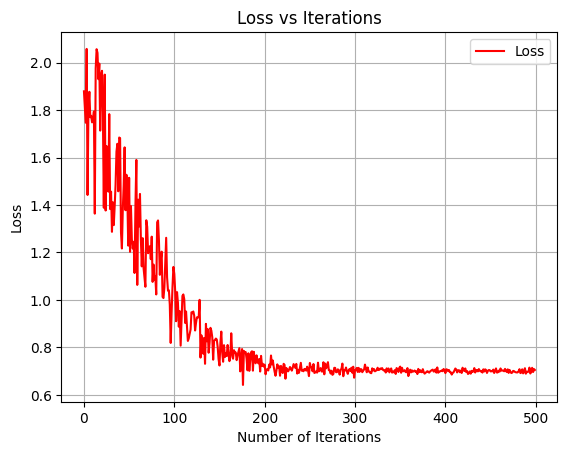

In [22]:
# Plotting loss w.r.t iterations
plt.plot(np.arange(500), mlp.loss, 'r', label='Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.grid()
